In [1]:
!pip install opencv-python
import cv2

In [2]:
import os

import matplotlib.pyplot as plt
import random
import torch
import numpy as np
import pandas as pd

import time #for measuring speed

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
#https://drive.google.com/file/d/1iDUceM9f4bTZOqX2mc-ucoNJ_DK8GuWa/view?usp=sharing


# import segmentation_models_pytorch as smp
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cuda', index=0)

In [3]:
print(torch.version.cuda)

12.1


# Data Loader

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from enum import Enum

class LABEL_MAP(Enum):
    NODATA=0
    Background=1
    Building=2
    Road=3
    Water=4
    Barren=5
    Forest=6
    Agricultural=7

NUM_CLASSES = 8
IMG_SIZE = 512

In [6]:
# Generate class weights from training set
out_dir = '/content/drive/My Drive/LoveDA_Dataset/output'

def str_to_list(s):
    if s.startswith('[') and s.endswith(']'):
        s = s[1:-1]  # Remove square brackets
        s = [int(item) for item in s.split(',')]  # Assuming integers in the list
        return s
    else:
        return []

def get_class_weights(folder_name, exclude_nodata = True):
    stats_filename = f"{out_dir}/{folder_name.lower()}.csv"
    stats_df = pd.read_csv(stats_filename, converters={'unique_classes': str_to_list, 'class_count': str_to_list})
    cols = ['unique_classes', 'class_count']
    stats_df = stats_df[cols].explode(cols)

    for col in cols:
        stats_df[col] = stats_df[col].astype(int)

    if exclude_nodata:
        nodata_mask = (stats_df['unique_classes'] == LABEL_MAP.NODATA.value)
        stats_df.loc[nodata_mask, 'class_count'] = 0

    grouped = stats_df.groupby('unique_classes')['class_count'].sum().reset_index()
    total_sum = grouped['class_count'].sum()

    grouped['weights'] = grouped['class_count'] / total_sum


    weights_dict = dict(zip(grouped['unique_classes'], grouped['weights']))

    return weights_dict

In [7]:
train_class_weights = get_class_weights('Train')
train_class_weights

{0: 0.0,
 1: 0.44035941805539147,
 2: 0.18859757981569503,
 3: 0.08689714597002755,
 4: 0.054022178089893624,
 5: 0.0757832467603697,
 6: 0.08758123146981778,
 7: 0.06675919983880484}

In [8]:
num_cpu_cores = os.cpu_count()
print(f"Number of CPU cores: {num_cpu_cores}")
num_workers = num_cpu_cores - 1

Number of CPU cores: 8


# Load into train / val / test sets

In [9]:
class LoveDA(Dataset):
    def __init__(self, data_dir, stats_file, transform=None):
        self.data_dir = data_dir

        self.transform = transform

        self.image_folder = os.path.join(data_dir, 'images')
        self.mask_folder = os.path.join(data_dir, 'masks')

        stats_df = pd.read_csv(stats_file)
        self.filenames = stats_df['filename'].to_list()

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_filename = self.filenames[idx]
        img_name = os.path.join(self.data_dir, 'images', img_filename)
        mask_name = os.path.join(self.data_dir,'masks', img_filename)

        image = Image.open(img_name)

        mask = cv2.imread(mask_name) # in numpy.ndarray (512, 512, 3)
        mask = torch.from_numpy(np.transpose(mask, (2, 0, 1)))
        # collapse duplicated labels
        mask = mask[0, :, :]

        if self.transform:
            cur = (image, mask)
            image, mask = self.transform(cur)

        return image, mask

In [10]:
def augmentation(current):
    input_image, input_mask = current

    to_tensor = transforms.ToTensor()
    input_image = to_tensor(input_image)

    # Random hue
    if random.random() > 0.5:
        hue = random.uniform(-0.10, 0.10)
        input_image = transforms.functional.adjust_hue(input_image, hue)

    # Random brightness adjustment
    if random.random() > 0.5:
        brightness_factor = random.uniform(0.90, 1.10)
        input_image = transforms.functional.adjust_brightness(input_image, brightness_factor)

    # Random contrast adjustment
    if random.random() > 0.5:
        contrast_factor = random.uniform(0.90, 1.10)
        input_image = transforms.functional.adjust_contrast(input_image, contrast_factor)

    # Random horizontal flip
    if random.random() > 0.5:
        input_image = transforms.functional.hflip(input_image)
        input_mask = transforms.functional.hflip(input_mask)

    # Random vertical flip
    if random.random() > 0.5:
        input_image = transforms.functional.vflip(input_image)
        input_mask = transforms.functional.vflip(input_mask)

    # Resize to the desired size
    resize = transforms.Resize((IMG_SIZE, IMG_SIZE))
    input_image = resize(input_image)
    input_mask = resize(input_mask)

    # Enforce mask values to be integers rounded up
    # input_mask = torch.ceil(input_mask * 255)

    return input_image, input_mask

In [11]:
custom_transform = transforms.Compose([
    augmentation
])

In [12]:
train_dataset = LoveDA(data_dir=f"{out_dir}/Train", stats_file=f"{out_dir}/train.csv", transform=custom_transform)
val_dataset = LoveDA(data_dir=f"{out_dir}/Val", stats_file=f"{out_dir}/val.csv", transform=custom_transform)
test_dataset = LoveDA(data_dir=f"{out_dir}/Test", stats_file=f"{out_dir}/test.csv", transform=custom_transform)

In [ ]:
def calculate_class_weights_and_distribution(dataset, num_classes):
    # Initialize arrays to store the counts of each class
    class_counts = torch.zeros(num_classes)
    total_count = len(dataset)

    # Iterate through the dataset to count class occurrences
    for i in range(total_count):
        _, mask = dataset[i]
        unique_values, value_counts = torch.unique(mask, return_counts=True)

        # Increment class counts based on unique values
        for unique_value, value_count in zip(unique_values, value_counts):
            class_counts[unique_value.item()] += value_count

    # Set weights based on the distribution
    class_weights = class_counts / total_count

    # Weights are inversly proportional to counts
    total_weight = class_weights.sum()
    class_weights = total_weight / class_weights

    # Convert tensors to lists for JSON serialization
    class_weights_list = class_weights.tolist()
    class_distribution = class_counts.tolist()

    return class_weights_list, class_distribution

class_distribution = []
class_weights_list = []

class_weights_list, class_distribution = calculate_class_weights_and_distribution(train_dataset, NUM_CLASSES)
print("Class Distribution:", class_distribution)
print("Class Weights List:", class_weights_list)

In [ ]:
from matplotlib.colors import ListedColormap

def show_random_image_mask(dataset, num_samples=4):
    plt.figure(figsize=(12, 3 * num_samples))

    colors = plt.cm.inferno(np.linspace(0,1,NUM_CLASSES))
    cmap = ListedColormap(colors)

    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)
        image, mask = dataset[idx]

        # Convert PyTorch tensors to NumPy arrays
        image = image.permute(1, 2, 0).cpu().numpy()
        mask = mask.cpu().numpy()

        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.imshow(image)
        plt.title("Image")
        plt.axis('off')

        plt.subplot(num_samples, 2, i * 2 + 2)
        mask_image = plt.imshow(mask, cmap=cmap, vmin=0, vmax=NUM_CLASSES - 1)
        plt.title("Mask")
        plt.axis('off')

        cbar = plt.colorbar(mask_image, ax=plt.gca().axes, orientation='vertical', ticks=np.linspace(0, NUM_CLASSES - 1, NUM_CLASSES))
        cbar.set_label('Class')

    plt.show()

In [ ]:
print(len(train_dataset))

1512


In [ ]:
# print("-------Train set-------")
# show_random_image_mask(train_dataset, num_samples=4)
# print("-------Val set-------")
# show_random_image_mask(val_dataset, num_samples=4)
# print("-------Test set-------")
# show_random_image_mask(test_dataset, num_samples=4)

In [ ]:
image, mask = train_dataset[0]
print(np.shape(image))
print(np.shape(mask))
print(mask)

torch.Size([3, 512, 512])
torch.Size([512, 512])
tensor([[7, 7, 7,  ..., 4, 4, 4],
        [7, 7, 7,  ..., 4, 4, 4],
        [7, 7, 7,  ..., 4, 4, 4],
        ...,
        [6, 6, 6,  ..., 7, 7, 7],
        [6, 6, 6,  ..., 7, 7, 7],
        [6, 6, 6,  ..., 7, 7, 7]], dtype=torch.uint8)


# Construct the UNet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# Defining modular blocks to implement a custom Unet.
# Main differences from the paper include the padding to make size matching easier
# Primarily 2 classes: Encoders and Decoders.
# Both use 2 convolutions per stage of the paper. We will define a "convolution block" class with variable number of layers

# Convolution Block Class: conv_block , optional specification for number of layers
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, num_layers=2):
    super(ConvBlock, self).__init__()

    layers = []
    for _ in range(num_layers):
      layers.extend([
          nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), #note of padding can make this slower than original implementation
          nn.BatchNorm2d(out_channels), # normalize at each step
          nn.ReLU() # use relu activation
      ])
      in_channels = out_channels  # Update in_channels for the next layer

    self.ConvBlock = nn.Sequential(*layers) #list of layers into sequential

  def forward(self, inputs):
      x = self.ConvBlock(inputs)
      return x

# Encoder class: returns output for skip connection and next encoder
class Encoder(nn.Module):
  def __init__(self, in_channels, out_channels, num_layers=2):
    super().__init__()
    self.conv = ConvBlock(in_channels, out_channels, num_layers) # default 2 conv
    self.pool = nn.MaxPool2d((2, 2))    #there are experiments on pooling features

  def forward(self, inputs):
    skip = self.conv(inputs)
    next = self.pool(skip)
    return skip, next

# Decoder class: takes an additional input (skip connection) and concatenates it to create a new layer
class Decoder(nn.Module):

    def __init__(self, in_channels, out_channels, num_layers=2):
      super().__init__()
      self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0) #de-convolution / upsampling
      self.conv = ConvBlock(out_channels + out_channels, out_channels, num_layers) # size is adjusted

    def forward(self, inputs, skip): #note skip should match output size
      x = self.up(inputs) # upscaling step
      x = torch.cat([x, skip], axis=1) # concatenate on the correct dimention [batch size, [data]]
      x = self.conv(x) #convolution
      return x

In [ ]:
# Helper function to see Unet params
def print_model_parameters(model):
    total_param = 0
    for name, param in model.named_parameters():
        print(name, param.size())
        print("Number of parameters at this level:", param.numel(), '\n')
        total_param += param.numel()

    print("Total number of parameters in the model:", total_param)

In [ ]:
# Reference UNET that closely follows the original implementation, the exception being the padding
# Param count:
class build_unet_base(nn.Module):

    def __init__(self):
      super().__init__()
      # """ Encoder """
      self.e1 = Encoder(3, 64)
      self.e2 = Encoder(64, 128)
      self.e3 = Encoder(128, 256)
      self.e4 = Encoder(256, 512)
      # """ Bottleneck """
      self.b = ConvBlock(512, 1024)
      # """ Decoder """
      self.d1 = Decoder(1024, 512)
      self.d2 = Decoder(512, 256)
      self.d3 = Decoder(256, 128)
      self.d4 = Decoder(128, 64)
      #  """ Classifier """
      self.outputs = nn.Conv2d(64, NUM_CLASSES, kernel_size=1, padding=0) #class size length

    def forward(self, inputs):
      # """ Encoder """
      s1, p1 = self.e1(inputs)
      s2, p2 = self.e2(p1)
      s3, p3 = self.e3(p2)
      s4, p4 = self.e4(p3)
      #  """ Bottleneck """
      b = self.b(p4)
      #  """ Decoder """
      d1 = self.d1(b, s4)
      d2 = self.d2(d1, s3)
      d3 = self.d3(d2, s2)
      d4 = self.d4(d3, s1)
      #  """ Classifier """
      outputs = self.outputs(d4)

      # normalized_outputs = torch.sigmoid(outputs)
      return outputs
      # return normalized_outputs

model = build_unet_base()
print_model_parameters(model)

e1.conv.ConvBlock.0.weight torch.Size([64, 3, 3, 3])
Number of parameters at this level: 1728 

e1.conv.ConvBlock.0.bias torch.Size([64])
Number of parameters at this level: 64 

e1.conv.ConvBlock.1.weight torch.Size([64])
Number of parameters at this level: 64 

e1.conv.ConvBlock.1.bias torch.Size([64])
Number of parameters at this level: 64 

e1.conv.ConvBlock.3.weight torch.Size([64, 64, 3, 3])
Number of parameters at this level: 36864 

e1.conv.ConvBlock.3.bias torch.Size([64])
Number of parameters at this level: 64 

e1.conv.ConvBlock.4.weight torch.Size([64])
Number of parameters at this level: 64 

e1.conv.ConvBlock.4.bias torch.Size([64])
Number of parameters at this level: 64 

e2.conv.ConvBlock.0.weight torch.Size([128, 64, 3, 3])
Number of parameters at this level: 73728 

e2.conv.ConvBlock.0.bias torch.Size([128])
Number of parameters at this level: 128 

e2.conv.ConvBlock.1.weight torch.Size([128])
Number of parameters at this level: 128 

e2.conv.ConvBlock.1.bias torch.Si

In [ ]:
# Building a shorter Unet
# Focus on the finer details

class build_unet_short(nn.Module):

    def __init__(self):
      super().__init__()
      # """ Encoder """
      self.e1 = Encoder(3, 128)
      self.e2 = Encoder(128, 128)
      self.e3 = Encoder(128, 256)
      # """ Bottleneck """
      self.b = ConvBlock(256, 512)
      # """ Decoder """
      self.d1 = Decoder(512, 256)
      self.d2 = Decoder(256, 128)
      self.d3 = Decoder(128, 128)
      #  """ Classifier """
      self.outputs = nn.Conv2d(128, NUM_CLASSES, kernel_size=1, padding=0) #class size length

    def forward(self, inputs):
      # """ Encoder """
      s1, p1 = self.e1(inputs)
      s2, p2 = self.e2(p1)
      s3, p3 = self.e3(p2)
      #  """ Bottleneck """
      b = self.b(p3)
      #  """ Decoder """
      d1 = self.d1(b, s3)
      d2 = self.d2(d1, s2)
      d3 = self.d3(d2, s1)
      #  """ Classifier """
      outputs = self.outputs(d3)

      # normalized_outputs = torch.sigmoid(outputs)
      # return normalized_outputs

      return outputs

model = build_unet_short()
print_model_parameters(model)

e1.conv.ConvBlock.0.weight torch.Size([128, 3, 3, 3])
Number of parameters at this level: 3456 

e1.conv.ConvBlock.0.bias torch.Size([128])
Number of parameters at this level: 128 

e1.conv.ConvBlock.1.weight torch.Size([128])
Number of parameters at this level: 128 

e1.conv.ConvBlock.1.bias torch.Size([128])
Number of parameters at this level: 128 

e1.conv.ConvBlock.3.weight torch.Size([128, 128, 3, 3])
Number of parameters at this level: 147456 

e1.conv.ConvBlock.3.bias torch.Size([128])
Number of parameters at this level: 128 

e1.conv.ConvBlock.4.weight torch.Size([128])
Number of parameters at this level: 128 

e1.conv.ConvBlock.4.bias torch.Size([128])
Number of parameters at this level: 128 

e2.conv.ConvBlock.0.weight torch.Size([128, 128, 3, 3])
Number of parameters at this level: 147456 

e2.conv.ConvBlock.0.bias torch.Size([128])
Number of parameters at this level: 128 

e2.conv.ConvBlock.1.weight torch.Size([128])
Number of parameters at this level: 128 

e2.conv.ConvBlo

In [ ]:
# Building a Unet with less depth per layer
# Focus on the finer details

class build_unet_skinny(nn.Module):

    def __init__(self):
        super().__init__()
        # """ Encoder """
        self.e1 = Encoder(3, 32, 1)
        self.e2 = Encoder(32, 64, 1)
        self.e3 = Encoder(64, 128, 1)
        self.e4 = Encoder(128, 256, 1)
        self.e5 = Encoder(256, 512, 1)
        self.e6 = Encoder(512, 512, 1)
        # """ Bottleneck """
        self.b = ConvBlock(512, 512, 1)
        # """ Decoder """
        self.d1 = Decoder(512, 512, 1)
        self.d2 = Decoder(512, 512, 1)
        self.d3 = Decoder(512, 256, 1)
        self.d4 = Decoder(256, 128, 1)
        self.d5 = Decoder(128, 64, 1)
        self.d6 = Decoder(64, 32, 1)
        #  """ Classifier """
        self.outputs = nn.Conv2d(32, NUM_CLASSES, kernel_size=1, padding=0) #class size length

    def forward(self, inputs):
        # """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        s5, p5 = self.e5(p4)
        s6, p6 = self.e6(p5)
        #  """ Bottleneck """
        b = self.b(p6)
        #  """ Decoder """
        d1 = self.d1(b, s6)
        d2 = self.d2(d1, s5)
        d3 = self.d3(d2, s4)
        d4 = self.d4(d3, s3)
        d5 = self.d5(d4, s2)
        d6 = self.d6(d5, s1)
        #  """ Classifier """
        outputs = self.outputs(d6)

        # normalized_outputs = torch.sigmoid(outputs)
        # return normalized_outputs

        return outputs

model = build_unet_skinny()
print_model_parameters(model)

e1.conv.ConvBlock.0.weight torch.Size([32, 3, 3, 3])
Number of parameters at this level: 864 

e1.conv.ConvBlock.0.bias torch.Size([32])
Number of parameters at this level: 32 

e1.conv.ConvBlock.1.weight torch.Size([32])
Number of parameters at this level: 32 

e1.conv.ConvBlock.1.bias torch.Size([32])
Number of parameters at this level: 32 

e2.conv.ConvBlock.0.weight torch.Size([64, 32, 3, 3])
Number of parameters at this level: 18432 

e2.conv.ConvBlock.0.bias torch.Size([64])
Number of parameters at this level: 64 

e2.conv.ConvBlock.1.weight torch.Size([64])
Number of parameters at this level: 64 

e2.conv.ConvBlock.1.bias torch.Size([64])
Number of parameters at this level: 64 

e3.conv.ConvBlock.0.weight torch.Size([128, 64, 3, 3])
Number of parameters at this level: 73728 

e3.conv.ConvBlock.0.bias torch.Size([128])
Number of parameters at this level: 128 

e3.conv.ConvBlock.1.weight torch.Size([128])
Number of parameters at this level: 128 

e3.conv.ConvBlock.1.bias torch.Siz

In [ ]:
from torchsummary import summary
# Improving on the best model / tuning
class build_unet_skinny_tuned(nn.Module):

    def __init__(self):
        super().__init__()
        # """ Encoder """
        self.e1 = Encoder(3, 32, 1)
        self.e2 = Encoder(32, 64, 1)
        self.e3 = Encoder(64, 128, 1)
        self.e4 = Encoder(128, 256, 1)
        self.e5 = Encoder(256, 512, 1)
        self.e6 = Encoder(512, 512, 1)
        # """ Bottleneck """
        self.b = ConvBlock(512, 1024, 1)
        # """ Decoder """
        self.d1 = Decoder(1024, 512, 1)
        self.d2 = Decoder(512, 512, 1)
        self.d3 = Decoder(512, 256, 1)
        self.d4 = Decoder(256, 128, 1)
        self.d5 = Decoder(128, 64, 1)
        self.d6 = Decoder(64, 32, 1)
        #  """ Classifier """
        self.dropout = nn.Dropout2d(p=0.5)
        self.outputs = nn.Conv2d(32, NUM_CLASSES, kernel_size=1, padding=0) #class size length

    def forward(self, inputs):
        # """ Encoder """
        s1, f = self.e1(inputs)
        s2, f = self.e2(f)
        s3, f = self.e3(f)
        s4, f = self.e4(f)
        s5, f = self.e5(f)
        s6, f = self.e6(f)
        #  """ Bottleneck """
        b = self.b(f)
        #  """ Decoder """
        d = self.d1(b, s6)
        d = self.d2(d, s5)
        d = self.d3(d, s4)
        d = self.d4(d, s3)
        d = self.d5(d, s2)
        d = self.d6(d, s1)
        #  """ Classifier """
        x = self.dropout(d)
        outputs = self.outputs(x)

        # normalized_outputs = torch.sigmoid(outputs)
        # return normalized_outputs

        return outputs

model = build_unet_skinny_tuned()
summary(model.cuda(), (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 512, 512]             896
       BatchNorm2d-2         [-1, 32, 512, 512]              64
              ReLU-3         [-1, 32, 512, 512]               0
         ConvBlock-4         [-1, 32, 512, 512]               0
         MaxPool2d-5         [-1, 32, 256, 256]               0
           Encoder-6  [[-1, 32, 512, 512], [-1, 32, 256, 256]]               0
            Conv2d-7         [-1, 64, 256, 256]          18,496
       BatchNorm2d-8         [-1, 64, 256, 256]             128
              ReLU-9         [-1, 64, 256, 256]               0
        ConvBlock-10         [-1, 64, 256, 256]               0
        MaxPool2d-11         [-1, 64, 128, 128]               0
          Encoder-12  [[-1, 64, 256, 256], [-1, 64, 128, 128]]               0
           Conv2d-13        [-1, 128, 128, 128]          73,856
      Bat

In [ ]:
# Building a Unet with less convolution per layer
# Focus on the finer details

class build_unet_less_conv(nn.Module):

    def __init__(self):
        super().__init__()
        # """ Encoder """
        self.e1 = Encoder(3, 32, 3)
        self.e2 = Encoder(32, 64, 3)
        self.e3 = Encoder(64, 128, 1)
        self.e4 = Encoder(128, 256, 1)
        self.e5 = Encoder(256, 512, 1)
        self.e6 = Encoder(512, 512, 1)
        # """ Bottleneck """
        self.b = ConvBlock(512, 512, 1)
        # """ Decoder """
        self.d1 = Decoder(512, 512, 1)
        self.d2 = Decoder(512, 512, 1)
        self.d3 = Decoder(512, 256, 1)
        self.d4 = Decoder(256, 128, 1)
        self.d5 = Decoder(128, 64, 3)
        self.d6 = Decoder(64, 32, 3)
        #  """ Classifier """
        self.outputs = nn.Conv2d(32, NUM_CLASSES, kernel_size=1, padding=0) #class size length

    def forward(self, inputs):
        # """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        s5, p5 = self.e5(p4)
        s6, p6 = self.e6(p5)
        #  """ Bottleneck """
        b = self.b(p6)
        #  """ Decoder """
        d1 = self.d1(b, s6)
        d2 = self.d2(d1, s5)
        d3 = self.d3(d2, s4)
        d4 = self.d4(d3, s3)
        d5 = self.d5(d4, s2)
        d6 = self.d6(d5, s1)
        #  """ Classifier """
        outputs = self.outputs(d6)

        # normalized_outputs = torch.sigmoid(outputs)
        # return normalized_outputs

        return outputs

model = build_unet_less_conv()
print_model_parameters(model)

In [ ]:
# Confirm model output is correct

model = build_unet_base()

image, mask = train_dataset[0]
y = model(image.unsqueeze(0).float())
print(y.shape)
print(y[0])

torch.Size([1, 8, 512, 512])
tensor([[[ 0.0165, -0.7953, -0.1996,  ...,  0.1321, -0.0413, -0.1836],
         [-0.4322, -0.7492, -1.0857,  ...,  0.0969, -0.4332, -0.3915],
         [-0.2002,  0.0236, -0.8490,  ..., -0.6174, -0.5657, -0.3799],
         ...,
         [ 0.2732, -0.3949, -0.3416,  ..., -0.9329, -0.8976, -0.6629],
         [-0.0132, -0.2252,  0.2014,  ..., -0.5026,  0.1060, -0.3587],
         [ 0.2126, -0.1191,  0.3261,  ...,  0.2917, -0.7153, -0.4636]],

        [[ 0.4347, -0.4555,  0.3614,  ...,  0.4172,  1.0999,  0.7216],
         [ 0.7243,  0.3582, -0.2771,  ...,  0.7500,  0.4502,  0.4828],
         [-0.0217,  0.5638, -0.8957,  ...,  0.0204,  0.0806,  0.8826],
         ...,
         [-0.0301,  0.1917, -1.0731,  ...,  0.5559, -0.3268, -0.3243],
         [ 1.7371,  2.0667,  0.8640,  ...,  0.5612, -0.6491, -0.2077],
         [-0.0682,  0.6213,  0.4267,  ...,  0.7682, -0.5999, -0.0605]],

        [[ 0.6057,  0.0411,  0.2439,  ...,  0.2590, -0.0580,  0.1993],
         [ 0.728

# Imported Models

In [ ]:
!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=0f90e6e2f7b3f2259476afddced9d36f1def6bed28f9a26aa594f3bb2b02f9ea
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=403634078356d85d87cd59f83a7bf5eba5055ea45b8966f334d32a213f54b29f
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
# Create Unet++ model with resnet34 encoder
ref_model_unetplusplus = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
)
print_model_parameters(ref_model_unetplusplus)

In [ ]:
# Create DeepLabV3+ model with resnet34 encoder
ref_model_deeplabv3plus = smp.DeepLabV3Plus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
)
print_model_parameters(ref_model_deeplabv3plus)

# Training the model

In [ ]:
import gc
#gc.collect()
#torch.cuda.empty_cache()

In [ ]:
"""
Jaccard Metric Losses: Optimizing the Jaccard Index with Soft Labels
<https://arxiv.org/abs/2302.05666>
Dice Semimetric Losses: Optimizing the Dice Score with Soft Labels
<https://arxiv.org/abs/2303.16296>
Revisiting Evaluation Metrics for Semantic Segmentation: Optimization and Evaluation of Fine-grained Intersection over Union
"""

import torch
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss


class JDTLoss(_Loss):
    def __init__(self,
                 mIoUD=1.0,
                 mIoUI=0.0,
                 mIoUC=0.0,
                 alpha=1.0,
                 beta=1.0,
                 gamma=1.0,
                 smooth=1.0,
                 threshold=0.01,
                 active_classes_mode_hard="PRESENT",
                 active_classes_mode_soft="ALL",
                 class_weights=None,
                 ignore_index=None,
                 device='cpu'):
        """
        Arguments:
            mIoUD (float): The weight of the loss to optimize mIoUD.
            mIoUI (float): The weight of the loss to optimize mIoUI.
            mIoUC (float): The weight of the loss to optimize mIoUC.
            alpha (float): The coefficient of false positives in the Tversky loss.
            beta (float): The coefficient of false negatives in the Tversky loss.
            gamma (float): When `gamma` > 1, the loss focuses more on
                less accurate predictions that have been misclassified.
            smooth (float): A floating number to avoid `NaN` error.
            threshold (float): The threshold to select active classes.
            active_classes_mode_hard (str): The mode to compute
                active classes when training with hard labels.
            active_classes_mode_soft (str): The mode to compute
                active classes when training with hard labels.
            class_weights (list[float] | None): The weight of each class.
                If it is `list[float]`, its size should be equal to the number of classes.
            ignore_index (int | None): The class index to be ignored.

        Comments:
            Jaccard: `alpha`  = 1.0, `beta`  = 1.0
            Dice:    `alpha`  = 0.5, `beta`  = 0.5
            Tversky: `alpha` >= 0.0, `beta` >= 0.0
        """
        super().__init__()

        assert mIoUD >= 0 and mIoUI >= 0 and mIoUC >= 0 and \
               alpha >= 0 and beta >= 0 and gamma >= 1 and \
               smooth >= 0 and threshold >= 0
        assert active_classes_mode_hard in \
               ["ALL", "PRESENT", "PROB", "LABEL", "BOTH"]
        assert active_classes_mode_soft in \
               ["ALL", "PRESENT", "PROB", "LABEL", "BOTH"]
        assert class_weights == None or \
               all((isinstance(w, float)) for w in class_weights)
        assert ignore_index == None or \
               isinstance(ignore_index, int)

        self.mIoUD = mIoUD
        self.mIoUI = mIoUI
        self.mIoUC = mIoUC
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.smooth = smooth
        self.threshold = threshold
        self.active_classes_mode_hard = active_classes_mode_hard
        self.active_classes_mode_soft = active_classes_mode_soft
        if class_weights == None:
            self.class_weights = class_weights
        else:
            self.class_weights = torch.tensor(class_weights).to(device)
        self.ignore_index = ignore_index


    def forward(self,
                logits,
                label,
                keep_mask=None):
        """
        Arguments:
            logits (torch.Tensor): Its shape should be (B, C, D1, D2, ...).
            label (torch.Tensor):
                If it is hard label, its shape should be (B, D1, D2, ...).
                If it is soft label, its shape should be (B, C, D1, D2, ...).
            keep_mask (torch.Tensor | None):
                If it is `torch.Tensor`,
                    its shape should be (B, D1, D2, ...) and
                    its dtype should be `torch.bool`.
        """
        batch_size, num_classes = logits.shape[:2]
        hard_label = label.dtype == torch.long

        logits = logits.view(batch_size, num_classes, -1)
        prob = logits.log_softmax(dim=1).exp()

        if keep_mask != None:
            assert keep_mask.dtype == torch.bool
            keep_mask = keep_mask.view(batch_size, -1)
            keep_mask = keep_mask.unsqueeze(1).expand(batch_size, num_classes, -1)
        elif self.ignore_index != None and hard_label:
            keep_mask = label != self.ignore_index
            keep_mask = keep_mask.view(batch_size, -1)
            keep_mask = keep_mask.unsqueeze(1).expand(batch_size, num_classes, -1)

        if hard_label:
            label = label.view(batch_size, -1)
            label = F.one_hot(
                torch.clamp(label, 0, num_classes - 1), num_classes=num_classes)
            label = label.permute(0, 2, 1).float()
            active_classes_mode = self.active_classes_mode_hard
        else:
            label = label.view(batch_size, num_classes, -1)
            active_classes_mode = self.active_classes_mode_soft

        assert prob.shape == label.shape and \
               (keep_mask == None or prob.shape == keep_mask.shape)

        loss = self.forward_loss(prob,
                                 label,
                                 keep_mask,
                                 active_classes_mode)

        return loss


    def forward_loss(self,
                     prob,
                     label,
                     keep_mask,
                     active_classes_mode):
        if keep_mask != None:
            prob = prob * keep_mask
            label = label * keep_mask

        cardinality = torch.sum(prob + label, dim=2)
        difference = torch.sum(torch.abs(prob - label), dim=2)
        intersection = (cardinality - difference) / 2
        fp = torch.sum(prob, dim=2) - intersection
        fn = torch.sum(label, dim=2) - intersection

        loss = 0
        batch_size, num_classes = prob.shape[:2]
        if self.mIoUD > 0:
            active_classes = self.compute_active_classes(prob,
                                                         label,
                                                         active_classes_mode,
                                                         num_classes,
                                                         (0, 2))
            loss_mIoUD = self.forward_loss_mIoUD(intersection,
                                                 fp,
                                                 fn,
                                                 active_classes)
            loss += self.mIoUD * loss_mIoUD

        if self.mIoUI > 0 or self.mIoUC > 0:
            active_classes = self.compute_active_classes(prob,
                                                         label,
                                                         active_classes_mode,
                                                         (batch_size, num_classes),
                                                         (2, ))
            loss_mIoUI, loss_mIoUC = self.forward_loss_mIoUIC(intersection,
                                                              fp,
                                                              fn,
                                                              active_classes)
            loss += self.mIoUI * loss_mIoUI + self.mIoUC * loss_mIoUC

        return loss


    def compute_active_classes(self,
                               prob,
                               label,
                               active_classes_mode,
                               shape,
                               dim):
        if active_classes_mode == "ALL":
            mask = torch.ones(shape, dtype=torch.bool)
        elif active_classes_mode == "PRESENT":
            mask = torch.amax(label, dim) > 0.5
        elif active_classes_mode == "PROB":
            mask = torch.amax(prob, dim) > self.threshold
        elif active_classes_mode == "LABEL":
            mask = torch.amax(label, dim) > self.threshold
        elif active_classes_mode == "BOTH":
            mask = torch.amax(prob + label, dim) > self.threshold

        active_classes = torch.zeros(shape,
                                     dtype=torch.bool,
                                     device=prob.device)
        active_classes[mask] = 1

        return active_classes


    def forward_loss_mIoUD(self,
                           intersection,
                           fp,
                           fn,
                           active_classes):
        if torch.sum(active_classes) < 1:
            return 0. * torch.sum(intersection)

        intersection = torch.sum(intersection, dim=0)
        fp = torch.sum(fp, dim=0)
        fn = torch.sum(fn, dim=0)
        tversky = (intersection + self.smooth) / \
            (intersection + self.alpha * fp + self.beta * fn + self.smooth)

        loss_mIoUD = 1.0 - tversky
        if self.gamma > 1:
            loss_mIoUD **= self.gamma
        if self.class_weights != None:
            loss_mIoUD *= self.class_weights

        loss_mIoUD = loss_mIoUD[active_classes]
        loss_mIoUD = torch.mean(loss_mIoUD)

        return loss_mIoUD


    def forward_loss_mIoUIC(self,
                            intersection,
                            fp,
                            fn,
                            active_classes):
        if torch.sum(active_classes) < 1:
            return 0. * torch.sum(intersection), \
                   0. * torch.sum(intersection)

        tversky = (intersection + self.smooth) / \
            (intersection + self.alpha * fp + self.beta * fn + self.smooth)

        loss_matrix = 1.0 - tversky
        if self.gamma > 1:
            loss_matrix **= self.gamma
        if self.class_weights != None:
            class_weights = self.class_weights.unsqueeze(0).expand(loss_matrix.shape)
            loss_matrix *= class_weights

        loss_matrix *= active_classes
        loss_mIoUI = self.reduce(loss_matrix,
                                 active_classes,
                                 1)
        loss_mIoUC = self.reduce(loss_matrix,
                                 active_classes,
                                 0)

        return loss_mIoUI, loss_mIoUC


    def reduce(self,
               loss_matrix,
               active_classes,
               dim):
        loss = torch.sum(loss_matrix, dim)
        active_sum = torch.sum(active_classes, dim)
        active_dim = active_sum > 0
        loss = loss[active_dim] / active_sum[active_dim]
        loss = torch.mean(loss)

        return loss

In [ ]:
# Opmtimizaion
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
scaler = GradScaler()

# Model Used

# build_unet_skinny() # build_unet_less_conv # ref_model_unetplusplus # ref_model_deeplabv3plus

model = build_unet_skinny_tuned() #ref_model_deeplabv3plus # ref_model_unetplusplus #build_unet_less_conv() # build_unet_skinny() # build_unet_base() # build_unet_short()

output_prefix = "build_unet_skinny_tuned_ab1"
model_description = output_prefix

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Configuration

logical_batch_size = 8 # make sure it's divisible by batch size
batch_size = 8 # Depends on vram limits / model
accumulation_steps = logical_batch_size / batch_size
num_epochs = 50
validation_interval = 1


# Normalized inverse class weights to sum to 1

# class_weights_list = [weight ** 0.5 for weight in class_weights_list] # root weights

# total_weight = sum(train_class_weights)
# normalized_class_weights = [weight / total_weight for weight in train_class_weights]
# class_weights = torch.tensor(normalized_class_weights, dtype=torch.float).to(device)
# print(class_weights)


# Loss Function
# class_weights_for_JDT = class_weights.cpu().numpy().tolist()
# criterion = JDTLoss(alpha=1, beta=1, gamma = 1.0 ,class_weights = class_weights_for_JDT, device = device).to(device)
# criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = JDTLoss(alpha=1, beta=1, gamma = 1.0 ,device = device).to(device)
loss_function = "JDTLoss(alpha=1, beta=1, gamma = 1.0 ,device = device)"

# class_weights_for_JDT = class_weights.cpu().numpy().tolist()
# criterion = JDTLoss(alpha=1, beta=1, gamma = 1.0 ,class_weights = class_weights_for_JDT, device = device).to(device)
# criterion = JDTLoss(alpha=1, beta=1, gamma = 1.0 ,device = device).to(device)
# criterion = nn.CrossEntropyLoss(weight=class_weights)
# criterion = smp.losses.JaccardLoss(mode = "multiclass", smooth = 0.5, from_logits = True).to(device)


# Optimizer and training optimizations

optimizer = torch.optim.Adam(model.parameters(), lr=0.001 , weight_decay = 0.001)
early_stopping_patience = 10 # 5->10
early_stopping_counter = 0
best_val_loss = float('inf')
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)#factor 0.1->0.5, patience 2->5

optimizer_and_params = "torch.optim.Adam(model.parameters(), lr=0.001 , weight_decay = 0.001)"


# Benchmarking / Model Setup

epoch_times = []
train_losses = []
val_losses = []
torch.cuda.empty_cache()
gc.collect()


# Set up data loaders and transformations

num_workers = 0 # MUST USE IN JUPYTER
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True)

# Training loop
# with torch.autograd.profiler.profile(use_cuda=True) as prof:
for epoch in range(num_epochs):
    # torch.cuda.empty_cache()
    start_time = time.time()
    model.train()
    running_loss = 0.0
    hasRemainder = True
    for i, (images, masks) in enumerate(train_dataloader, 0):
        with autocast():
            images, masks = images.to(device), masks.to(device)
            outputs = model(images.float())
            target_masks = masks.squeeze(1).long()
            loss = criterion(outputs, target_masks)
            scaler.scale(loss).backward()

            hasRemainder = True
            if (i + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                hasRemainder = False

            running_loss += loss.item()

            if epoch < 1 and i % 100 == 0:
                print(f"Loss {loss}")

    # Update any accumulated weights after epoch
    if(hasRemainder):
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    avg_train_loss = running_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss}")
    train_losses.append(avg_train_loss)

    # Free memory on completion of loop
    torch.cuda.empty_cache()
    gc.collect()

    # Validation loop
    if (epoch + 1) % validation_interval == 0:  # Validate every 'validation_interval' epochs
        model.eval()
        total_loss = 0.0

        for i, (images, masks) in enumerate(val_dataloader, 0):
            images, masks = images.to(device), masks.to(device)
            target_masks = masks.squeeze(1).long()

            with torch.no_grad():
                outputs = model(images.float())

            loss = criterion(outputs, target_masks)
            total_loss += loss.item()


        avg_val_loss = total_loss / len(val_dataloader)
        print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss}")
        val_losses.append(avg_val_loss)


    # Check for early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= early_stopping_patience:
        print(f"Early stopping after {epoch + 1} epochs without improvement.")
        break

    # Update learning rate based on validation loss
    lr_scheduler.step(avg_val_loss)

    # Performance metric
    end_time = time.time()
    elapsed_time = end_time - start_time
    epoch_times.append(elapsed_time)
    print(f"Epoch {epoch + 1} - Elapsed Time: {elapsed_time:.2f} seconds")

    # Free memory on completion of loop
    torch.cuda.empty_cache()
    gc.collect()

# print(prof)

Loss 0.9458621144294739
Loss 0.8874637484550476
Epoch 1, Train Loss: 0.8764504935375597
Epoch 1, Validation Loss: 0.8686452007293701
Epoch 1 - Elapsed Time: 66.07 seconds
Epoch 2, Train Loss: 0.8293463319697708
Epoch 2, Validation Loss: 0.8514094841480255
Epoch 2 - Elapsed Time: 68.27 seconds
Epoch 3, Train Loss: 0.8075849511635997
Epoch 3, Validation Loss: 0.853438048362732
Epoch 3 - Elapsed Time: 67.47 seconds
Epoch 4, Train Loss: 0.8066293559377156
Epoch 4, Validation Loss: 0.8696865415573121
Epoch 4 - Elapsed Time: 67.41 seconds
Epoch 5, Train Loss: 0.8047529742831275
Epoch 5, Validation Loss: 0.8382648336887359
Epoch 5 - Elapsed Time: 68.36 seconds
Epoch 6, Train Loss: 0.7970125236839214
Epoch 6, Validation Loss: 0.8483901476860046
Epoch 6 - Elapsed Time: 67.72 seconds
Epoch 7, Train Loss: 0.7996245685708586
Epoch 7, Validation Loss: 0.8105487430095673
Epoch 7 - Elapsed Time: 67.40 seconds
Epoch 8, Train Loss: 0.7955952769234067
Epoch 8, Validation Loss: 0.8194383811950684
Epoch 8

# Validate Model

In [ ]:
model_res_dir = '/content/drive/My Drive/LoveDA_Dataset/model_export'

In [ ]:
average_time_per_epoch = sum(epoch_times) / len(epoch_times)
print(f"Average Time per Epoch: {average_time_per_epoch:.2f} seconds")
print(f"total time elapsed is {sum(epoch_times)} seconds")

Average Time per Epoch: 67.42 seconds
total time elapsed is 3370.878253221512 seconds


In [ ]:
from torchsummary import summary

summary(model.cuda(), (3, 512, 512))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 512, 512]             896
       BatchNorm2d-2         [-1, 32, 512, 512]              64
              ReLU-3         [-1, 32, 512, 512]               0
         ConvBlock-4         [-1, 32, 512, 512]               0
         MaxPool2d-5         [-1, 32, 256, 256]               0
           Encoder-6  [[-1, 32, 512, 512], [-1, 32, 256, 256]]               0
            Conv2d-7         [-1, 64, 256, 256]          18,496
       BatchNorm2d-8         [-1, 64, 256, 256]             128
              ReLU-9         [-1, 64, 256, 256]               0
        ConvBlock-10         [-1, 64, 256, 256]               0
        MaxPool2d-11         [-1, 64, 128, 128]               0
          Encoder-12  [[-1, 64, 256, 256], [-1, 64, 128, 128]]               0
           Conv2d-13        [-1, 128, 128, 128]          73,856
      Bat

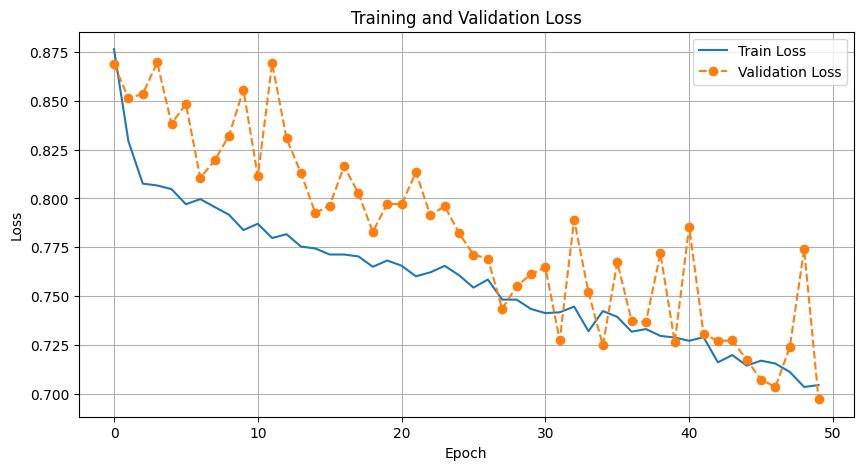

In [ ]:
# Plot training loss characteristics

plt.figure(figsize=(10, 5))
plt.plot(range(0, len(train_losses)), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(0, len(val_losses)), val_losses, label='Validation Loss', linestyle='--', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Save the figure as an image
output_plot_path = f"{model_res_dir}/{output_prefix}_training_validation_loss_plot.png"
plt.savefig(output_plot_path)

plt.show()

In [ ]:
#Metrics
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

# Evaluation loop
model.eval()
total_test_loss = 0.0

# Initialize metrics variables
total_tp, total_fp, total_fn, total_tn = torch.tensor([]), torch.tensor([]), torch.tensor([]), torch.tensor([])

for i, (images, masks) in enumerate(test_dataloader, 0):
    images, masks = images.to(device), masks.to(device)
    target_masks = masks.squeeze(1).long()

    with torch.no_grad():
        outputs = model(images.float())

    loss = criterion(outputs, target_masks)
    total_test_loss += loss.item()

    # Convert model outputs to predicted labels
    _, predicted_labels = torch.max(outputs, 1)

    # Compute metrics for each batch
    tp, fp, fn, tn = smp.metrics.get_stats(predicted_labels, target_masks, mode='multiclass', num_classes=NUM_CLASSES)

    # Append scores for each batch
    total_tp = torch.cat((total_tp, tp), dim=0)
    total_fp = torch.cat((total_fp, fp), dim=0)
    total_fn = torch.cat((total_fn, fn), dim=0)
    total_tn = torch.cat((total_tn, tn), dim=0)

    # print(total_tp.shape)

avg_test_loss = total_test_loss / len(test_dataloader)
print(f"Test Loss: {avg_test_loss}")

Test Loss: 0.6990074461600819


In [ ]:
# Compute and print metrics for overall pixels predicted correct
reduction = "micro"

iou_score = smp.metrics.iou_score(total_tp, total_fp, total_fn, total_tn, reduction=reduction)
f1_score = smp.metrics.f1_score(total_tp, total_fp, total_fn, total_tn, reduction=reduction)
f2_score = smp.metrics.fbeta_score(total_tp, total_fp, total_fn, total_tn, beta=2, reduction=reduction)
accuracy = smp.metrics.accuracy(total_tp, total_fp, total_fn, total_tn, reduction=reduction)
recall = smp.metrics.recall(total_tp, total_fp, total_fn, total_tn, reduction=reduction)

print(f"IoU Score: {iou_score}")
print(f"F1 Score: {f1_score}")
print(f"F2 Score: {f2_score}")
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")

IoU Score: 0.37806347012519836
F1 Score: 0.5486880540847778
F2 Score: 0.5486880540847778
Accuracy: 0.8871719837188721
Recall: 0.5486880540847778


In [ ]:
def calculate_class_iou_one_image_at_a_time(model, dataset, num_classes):
    model.eval()
    iou_per_class = torch.zeros(num_classes)
    class_count = torch.zeros(num_classes)
    epsilon = 1e-10  # Small epsilon to avoid division by zero

    with torch.no_grad():
        for image, target in dataset:
            image, target = image.unsqueeze(0).cuda(), target.cuda()

            output = model(image)
            pred = torch.argmax(output, dim=1)

            for cls in range(num_classes):
                class_present_mask = (target == cls) | (pred == cls)

                intersection = (class_present_mask & (pred == cls) & (target == cls)).sum().float().item()
                union = class_present_mask.sum().float().item()

                if union > 0:
                    iou = intersection / union
                    iou_per_class[cls] += iou
                    class_count[cls] += 1  # added to total cases

    class_iou = iou_per_class / (class_count + epsilon)  # Avoid division by zero
    return class_iou.tolist(), class_count.tolist()

num_classes = NUM_CLASSES
iou_per_class, test_class_count = calculate_class_iou_one_image_at_a_time(model.eval(), test_dataset, num_classes)

for cls, iou in enumerate(iou_per_class):
    print(f"Class {cls}: mIOU = {iou:.4f}, Count = {test_class_count[cls]}")

total_iou = sum(iou_per_class)
mIOU = total_iou / num_classes
print(f"Mean IOU across all classes: {mIOU:.4f}")

Class 0: mIOU = 0.2784, Count = 158.0
Class 1: mIOU = 0.4200, Count = 488.0
Class 2: mIOU = 0.2246, Count = 481.0
Class 3: mIOU = 0.1058, Count = 478.0
Class 4: mIOU = 0.0813, Count = 451.0
Class 5: mIOU = 0.0806, Count = 480.0
Class 6: mIOU = 0.1582, Count = 408.0
Class 7: mIOU = 0.0051, Count = 470.0
Mean IOU across all classes: 0.1692


In [ ]:
# Visualize output
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg

# Set your model to evaluation mode
model.eval()

# Define the number of samples to visualize
num_samples_to_visualize = 32 / batch_size  # Change this to the desired number of samples

# Iterate through a limited number of examples from the validation dataset
num_classes = NUM_CLASSES
colors = plt.cm.inferno(np.linspace(0, 1, num_classes))
cmap = ListedColormap(colors)

# Create a directory to store individual plots
individual_plots_dir = f"{model_res_dir}/{output_prefix}_individual_plots"
os.makedirs(individual_plots_dir, exist_ok=True)
individual_plot_paths = []

# Create a list to store the individual plots
all_plots = []
for i, (images, masks) in enumerate(val_dataloader, 0):
    if i >= num_samples_to_visualize:
        break

    images, masks = images.to(device), masks.to(device)

    # Forward pass to get predictions
    with torch.no_grad():
        outputs = model(images.float())

    # Convert predicted masks and expected masks to CPU and numpy arrays
    predicted_masks = outputs.cpu().numpy()
    expected_masks = masks.cpu().numpy()

    # Find the index of the maximum value across all channels for each pixel
    max_predicted_mask_index = np.argmax(predicted_masks, axis=1)

    # Plot the input image, max predicted mask, and expected mask
    for j in range(images.size(0)):  # Loop through the batch

        plt.figure(figsize=(12, 4))

        # Plot the input image
        plt.subplot(1, 3, 1)
        plt.imshow(np.transpose(images[j].cpu().numpy(), (1, 2, 0))) # Fixed
        #plt.imshow(images[j, 0].cpu().numpy())
        plt.title("Input Image")
        plt.axis('off')

        # Plot the max predicted mask as the index of the highest value
        plt.subplot(1, 3, 2)
        im = plt.imshow(max_predicted_mask_index[j], cmap=cmap, vmin=0, vmax=num_classes - 1) # plt.imshow(max_predicted_mask_index[j], cmap='gray')  # Use a different colormap for better visualization
        plt.title("Max Predicted Mask Index")
        plt.axis('off')
        # print(max_predicted_mask_index[j])

        # Plot the expected mask
        plt.subplot(1, 3, 3)
        im = plt.imshow(expected_masks[j], cmap=cmap, vmin=0, vmax=num_classes - 1)  # Ensure the correct range plt.imshow(expected_masks[j, 0], cmap='gray')
        plt.title("Expected Mask")
        plt.axis('off')

        # Create a colorbar using the custom colormap
        cbar = plt.colorbar(im, ax=plt.gca().axes, orientation='vertical', ticks=np.linspace(0, num_classes - 1, num_classes))
        cbar.set_label('Class')

        # Append the current plot to the list
        all_plots.append(plt)
        individual_plot_path = os.path.join(individual_plots_dir, f"plot_{len(all_plots)}.png")
        plt.savefig(individual_plot_path, bbox_inches='tight', pad_inches=0.1)
        individual_plot_paths.append(individual_plot_path)
        print(f"Individual plot saved to {individual_plot_path}")

# Create a single plot with all subplots
fig, axes = plt.subplots(len(all_plots), 1, figsize=(10, 5 * len(all_plots)))
for i, (plot, path) in enumerate(zip(all_plots, individual_plot_paths)):
    img = plt.imread(path)
    axes[i].imshow(img)
    axes[i].axis('off')

output_image_path = f"{model_res_dir}/{output_prefix}_visualization_plot.png"
fig.savefig(output_image_path, bbox_inches='tight', pad_inches=0.1)
print(f"Visualization plot saved to {output_image_path}")
plt.show()

# # Show all plots
# for plot in all_plots:
#     plot.show()

In [ ]:
# OUTPUT TO FILE

# Save parameter count and structure to a text file
output_file_path = f"{model_res_dir}/{output_prefix}_model_info.txt"
from IPython.utils import io
with io.capture_output() as captured:
    # Print the summary
    summary(model.cuda(), (3, 512, 512))

# Save the captured output to the file
with open(output_file_path, 'w') as file:
    file.write(captured.stdout)

# Print a message indicating where the summary has been saved
print(f"Model summary saved to {output_file_path}")

Model summary saved to /content/drive/My Drive/LoveDA_Dataset/model_export/build_unet_skinny_tuned_ab1_model_info.txt


In [ ]:
def save_training_benchmarks(model_description, optimizer_and_params, loss_function, logical_batch_size, batch_size,
                              average_training_time_per_epoch, mIOU_all_classes, mIOU_per_class):
    # Save training benchmarks to a text file
    output_file_path = f"{model_res_dir}/{output_prefix}_training_benchmarks.txt"
    with open(output_file_path, "w") as output_file:
        # Model description
        output_file.write(f"Model Description:\n{model_description}\n\n")

        # Optimizer and parameters
        output_file.write(f"Optimizer and Parameters:\n{optimizer_and_params}\n\n")

        # Loss function
        output_file.write(f"Loss Function:\n{loss_function}\n\n")

        # Batch size
        output_file.write(f"Logical Batch Size: {logical_batch_size}\n")
        output_file.write(f"Batch Size: {batch_size}\n\n")

        # Benchmark values
        output_file.write(f"Average Training Time per Epoch: {average_training_time_per_epoch:.4f} seconds\n")

        output_file.write("mIOU across all classes:\n")
        output_file.write(f"{mIOU_all_classes:.4f}\n\n")

        output_file.write("mIOU for each class:\n")
        for cls, mIOU in enumerate(mIOU_per_class):
            output_file.write(f"Class {cls}: {mIOU:.4f}\n")

    print(f"Training benchmarks written to {output_file_path}")

save_training_benchmarks(model_description, optimizer_and_params, loss_function, logical_batch_size, batch_size,
                          average_time_per_epoch, mIOU, iou_per_class)

Training benchmarks written to /content/drive/My Drive/LoveDA_Dataset/model_export/build_unet_skinny_tuned_ab1_training_benchmarks.txt
